In [6]:
import os
from PIL import Image

DATA_DIR = "top10pintores"

bad_files = []

for root, dirs, files in os.walk(DATA_DIR):
    for f in files:
        full_path = os.path.join(root, f)

        # ignorar archivos ocultos o del sistema
        if f.startswith('.') or f.lower().endswith('.txt') or f.lower().endswith('.json'):
            print("❌ Archivo NO imagen eliminado:", full_path)
            os.remove(full_path)
            continue
        
        try:
            img = Image.open(full_path)
            img.verify()  # Verifica si es una imagen válida
        except Exception:
            print("❌ Imagen corrupta ELIMINADA:", full_path)
            bad_files.append(full_path)
            try:
                os.remove(full_path)
            except:
                pass

print("\n🧹 Total archivos corruptos eliminados:", len(bad_files))


❌ Imagen corrupta ELIMINADA: top10pintores\nicholas-roerich\701.jpg

🧹 Total archivos corruptos eliminados: 1


In [7]:
import shutil

for root, dirs, files in os.walk(DATA_DIR):
    for d in dirs:
        if d.startswith('.') or d.lower().startswith('__') or 'checkpoint' in d.lower():
            path = os.path.join(root, d)
            print("🗑 Eliminando carpeta basura:", path)
            shutil.rmtree(path, ignore_errors=True)


🗑 Eliminando carpeta basura: top10pintores\.ipynb_checkpoints


In [20]:
# ============================================
# 📌 IMPORTS
# ============================================
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# ============================================
# 📁 DIRECTORIOS
# ============================================
DATA_DIR = "top10pintores"
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

IMG_SIZE = 224
BATCH_SIZE = 128
EPOCHS = 30

# ============================================
# 🔤 Obtener nombres de clases
# ============================================
class_names = sorted([
    d for d in os.listdir(DATA_DIR)
    if os.path.isdir(os.path.join(DATA_DIR, d)) and not d.startswith('.')
])
print("Clases detectadas:", class_names)

with open(os.path.join(MODEL_DIR, "class_names.json"), "w") as f:
    json.dump(class_names, f)

# ============================================
# 🧹 DATA AUGMENTATION
# ============================================
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=60,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
)

val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
)

# ============================================
# 🧠 MODELO MOBILE NET V2
# ============================================
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
preds = Dense(len(class_names), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=preds)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ============================================
# 🛑 CALLBACKS
# ============================================
callbacks = [
    EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    ModelCheckpoint(
        filepath=os.path.join(MODEL_DIR, "model_3.h5"),
        monitor="val_accuracy",
        save_best_only=True
    )
]

# ============================================
# 🚀 ENTRENAMIENTO
# ============================================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)


Clases detectadas: ['camille-pissarro', 'claude-monet', 'john-singer-sargent', 'marc-chagall', 'nicholas-roerich', 'pablo-picasso', 'pierre-auguste-renoir', 'pyotr-konchalovsky', 'rembrandt', 'vincent-van-gogh']
Found 3935 images belonging to 10 classes.
Found 981 images belonging to 10 classes.
Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3019 - loss: 2.4411

31/31 ━━━━━━━━━━━━━━━━━━━━ 316s 8s/step - accuracy: 0.4150 - loss: 1.9261 - val_accuracy: 0.6391 - val_loss: 1.1165
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5647 - loss: 1.3560

31/31 ━━━━━━━━━━━━━━━━━━━━ 237s 8s/step - accuracy: 0.5832 - loss: 1.3259 - val_accuracy: 0.6758 - val_loss: 0.9585
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 231s 7s/step - accuracy: 0.6358 - loss: 1.1785 - val_accuracy: 0.6656 - val_loss: 1.0286
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6378 - loss: 1.1387

31/31 ━━━━━━━━━━━━━━━━━━━━ 287s 9s/step - accuracy: 0.6338 - loss: 1.1619 - val_accuracy: 0.7095 - val_loss: 0.9316
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 200s 6s/step - accuracy: 0.6557 - loss: 1.0701 - val_accuracy: 0.7013 - val_loss: 0.9784
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 209s 7s/step - accuracy: 0.6572 - loss: 1.0549 - val_accuracy: 0.6983 - val_loss: 0.9370
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 193s 6s/step - accuracy: 0.6590 - loss: 1.0708 - val_accuracy: 0.6972 - val_loss: 0.9942
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6677 - loss: 1.0656

31/31 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - accuracy: 0.6574 - loss: 1.1044 - val_accuracy: 0.7166 - val_loss: 0.9065
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 180s 6s/step - accuracy: 0.6666 - loss: 1.0709 - val_accuracy: 0.6962 - val_loss: 0.9658
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 229s 7s/step - accuracy: 0.6587 - loss: 1.0760 - val_accuracy: 0.6881 - val_loss: 1.0099
Epoch 11/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 192s 6s/step - accuracy: 0.6640 - loss: 1.0793 - val_accuracy: 0.7125 - val_loss: 0.9234
Epoch 12/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 200s 6s/step - accuracy: 0.6671 - loss: 1.1005 - val_accuracy: 0.7074 - val_loss: 0.9548


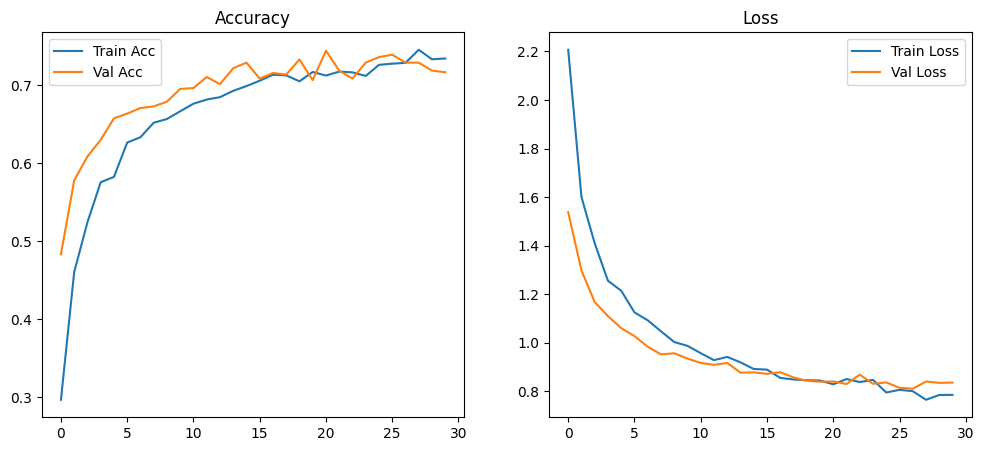

Modelo guardado en: models\model_2.h5
Clases guardadas en: models\class_names.json


In [17]:

# ============================================
# 📊 MÉTRICAS
# ============================================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()



print("Modelo guardado en:", os.path.join(MODEL_DIR, "model_2.h5"))
print("Clases guardadas en:", os.path.join(MODEL_DIR, "class_names.json"))
